# Fitbit Identifier

- Steven Garis & Matthew Capper

## Imports

In [1]:
import zgulde.extend_pandas
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
from scipy import stats

import itertools

# data visualization 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels.api as sm
from pylab import rcParams


%matplotlib inline


from fbprophet import Prophet



# ignore warnings
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Functions

In [2]:
# Used to get more datetime fields to work with.
def expand_dt(df):
    df['time'] = df.index
    df['year'] = df.time.dt.year
    df['quarter'] = df.time.dt.quarter
    df['month'] = df.time.dt.month
    df['day_of_month'] = df.time.dt.day
    df['day_of_week'] = df.time.dt.day_name().str[:3]
    df['is_weekend'] = ((pd.DatetimeIndex(df.index).dayofweek) > 4)
    df.drop(columns=['time'], inplace=True)
    return df



## Data Acquisition

- CSVs were provided with the thumb drive

In [3]:
# Making each csv a DataFrame that is split on new line

a = '2018-04-26_through_2018-05-26.csv'
b = '2018-05-27_through_2018-06-26.csv'
c = '2018-06-27_through_2018-07-27.csv'
d = '2018-07-28_through_2018-08-26.csv'
e = '2018-08-27_through_2018-09-26.csv'
g = '2018-09-27_through_2018-10-27.csv'
h = '2018-10-28_through-2018-11-27.csv'
i = '2018-11-28_through_2018-12-28.csv'

FILE = a
with open(FILE) as f:
    contents = f.read()
a = contents.split('\n')
a = pd.DataFrame(a)

FILE = b
with open(FILE) as f:
    contents = f.read()
b = contents.split('\n')
b = pd.DataFrame(b)

FILE = c
with open(FILE) as f:
    contents = f.read()
c = contents.split('\n')
c = pd.DataFrame(c)

FILE = d
with open(FILE) as f:
    contents = f.read()
d = contents.split('\n')
d = pd.DataFrame(d)

FILE = e
with open(FILE) as f:
    contents = f.read()
e = contents.split('\n')
e = pd.DataFrame(e)

FILE = g
with open(FILE) as f:
    contents = f.read()
g = contents.split('\n')
g = pd.DataFrame(g)

FILE = h
with open(FILE) as f:
    contents = f.read()
h = contents.split('\n')
h = pd.DataFrame(h)

FILE = i
with open(FILE) as f:
    contents = f.read()
i = contents.split('\n')
i = pd.DataFrame(i)


## Data Preparation

In [4]:
# Grabbing just the Activities section. All the other sections were filled with a 0.
a = a.iloc[35:67]
b = b.iloc[36:67]
c = c.iloc[36:67]
d = d.iloc[35:65]
e = e.iloc[36:67]
g = g.iloc[36:67]
h = h.iloc[36:67]
i = i.iloc[36:45]

# Combining them in order of the date 
df = a.append(b).append(c).append(d).append(e).append(g).append(h).append(i)
df = df.reset_index()


In [5]:
# Splitting into columns 
df = df[0].str.split('","', expand=True)

# Renaming the colums
df.rename(columns={0: 'date', 
                   1: 'calories_burned', 
                   2: 'steps', 
                   3: 'distance',
                   4: 'floors',
                   5: 'minutes_sedentary',
                   6: 'minutes_lightly_active',
                   7: 'minutes_fairly_active',
                   8: 'minutes_very_active',
                   9: 'activity_calories'}, inplace=True)

# Dropping the old columns names that could't split.
df.drop(index=0, inplace=True)

# Removing the '"' that got left over
df['activity_calories'] = df.activity_calories.str.replace('"','')
df['date'] = df.date.str.replace('"','')

# Removing ',' from numbers
df["calories_burned"] = df.calories_burned.str.replace(',','')
df["steps"] = df.steps.str.replace(',','')
df["minutes_sedentary"] = df.minutes_sedentary.str.replace(',','')
df["activity_calories"] = df.activity_calories.str.replace(',','')

# Setting date to datetime and setting as index
df['date'] = pd.to_datetime(df.date)
df.set_index('date', inplace=True)


# Getting a list of columns
columns = df.columns

# Converting from object to numeric
df[columns] = df[columns].apply(pd.to_numeric, errors='coerce')

# Expanding DT 
df = expand_dt(df)

#### Checking the prep:

- We have all the dates from the min to max but...
- We are missing dates from 2018-12-07 to 2018-12-28
- There are no missing values

In [6]:
print('Total days: ', df.index.nunique())
print('Start date: ',df.index.min())
print('End date  : ',df.index.max())

Total days:  225
Start date:  2018-04-26 00:00:00
End date  :  2018-12-06 00:00:00


In [7]:
# Checking to see if there are missing dates from min to max

timedelta(df.index.nunique()) == (df.index.max() - df.index.min()) + timedelta(days=1)


True

In [8]:
df.dtypes

calories_burned             int64
steps                       int64
distance                  float64
floors                      int64
minutes_sedentary           int64
minutes_lightly_active      int64
minutes_fairly_active       int64
minutes_very_active         int64
activity_calories           int64
year                        int64
quarter                     int64
month                       int64
day_of_month                int64
day_of_week                object
is_weekend                   bool
dtype: object

In [9]:
df.isnull().sum()

calories_burned           0
steps                     0
distance                  0
floors                    0
minutes_sedentary         0
minutes_lightly_active    0
minutes_fairly_active     0
minutes_very_active       0
activity_calories         0
year                      0
quarter                   0
month                     0
day_of_month              0
day_of_week               0
is_weekend                0
dtype: int64

## Data Exploration

In [10]:
df.index.max() - timedelta(weeks=4)

Timestamp('2018-11-08 00:00:00', freq='D')

In [11]:
train = df[:'2018-11-08']
test = df['2018-11-08':]



# aggregation = 'mean'
# train = df[:'2018-11-08'].resample('M').agg(aggregation)
# test = df['2018-11-08':].resample('M').agg(aggregation)



In [12]:
train.describe()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,year,quarter,month,day_of_month
count,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.0,197.000000,197.000000,197.000000
mean,3352.994924,7859.944162,3.711574,9.994924,835.096447,180.629442,14.401015,30.040609,1402.350254,2018.0,2.862944,7.553299,15.685279
std,638.501302,5065.369218,2.395296,19.361359,246.743248,75.324128,15.368487,35.503785,738.788103,0.0,0.718912,1.885349,9.102726
min,799.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,2018.0,2.000000,4.000000,1.000000
25%,3043.000000,4446.000000,2.100000,2.000000,674.000000,152.000000,2.000000,0.000000,999.000000,2018.0,2.000000,6.000000,8.000000
50%,3348.000000,7034.000000,3.320000,6.000000,773.000000,196.000000,10.000000,13.000000,1388.000000,2018.0,3.000000,8.000000,16.000000
75%,3719.000000,11061.000000,5.220000,11.000000,907.000000,232.000000,20.000000,56.000000,1817.000000,2018.0,3.000000,9.000000,24.000000
max,5199.000000,21302.000000,10.050000,162.000000,1440.000000,349.000000,78.000000,125.000000,3596.000000,2018.0,4.000000,11.000000,31.000000


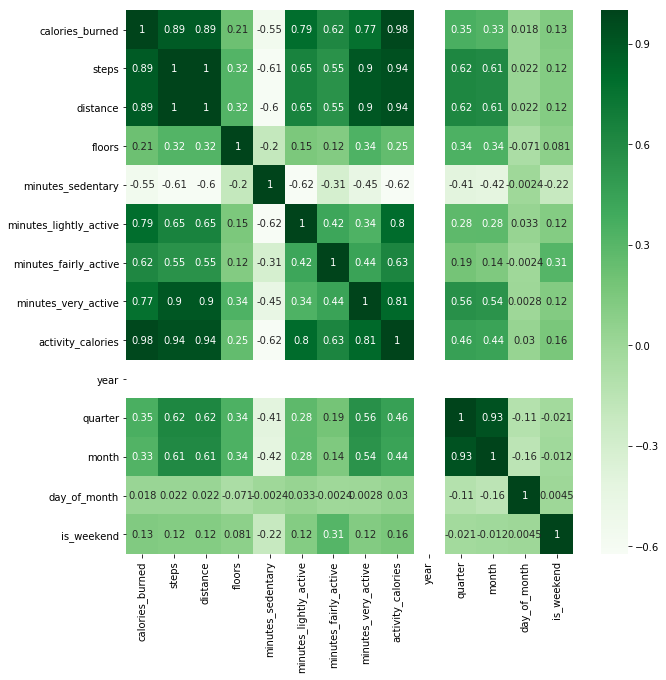

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(data=train.corr(), annot=True, cmap='Greens')

In [14]:
df.groupby('day_of_week')[['calories_burned','steps','distance','floors']].mean()

,calories_burned,steps,distance,floors
day_of_week,,,,
Fri,3464.718750,8847.250000,4.180625,11.062500
Mon,3242.750000,7245.406250,3.439688,6.718750
Sat,3553.187500,9549.656250,4.591563,13.562500
Sun,3551.468750,9904.500000,4.669062,21.843750
Thu,3425.939394,8748.636364,4.157576,12.545455
Tue,3304.093750,7856.875000,3.702813,11.250000
Wed,3270.468750,7594.343750,3.582812,11.156250


In [15]:
# Looks like they are mostly active on the weekends

df.groupby('is_weekend')[['calories_burned','steps','distance','floors']].mean()

,calories_burned,steps,distance,floors
is_weekend,,,,
False,3342.118012,8062.788820,3.814845,10.559006
True,3552.328125,9727.078125,4.630312,17.703125


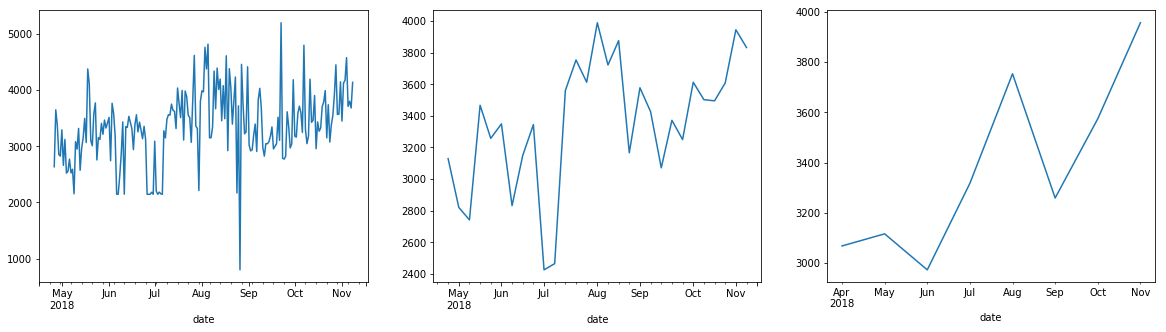

In [16]:
# sns.tsplot or sns.lineplot

plt.figure(figsize=(20,5))

plt.subplot(131)
train.resample('D').calories_burned.mean().plot()

plt.subplot(132)
train.resample('W').calories_burned.mean().plot()

plt.subplot(133)
train.resample('M').calories_burned.mean().plot()


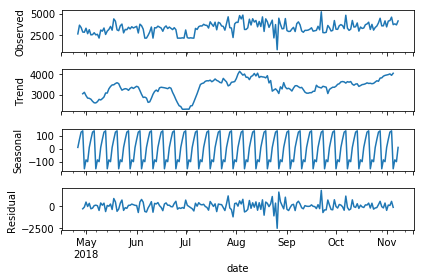

In [17]:
cal_burn = train.resample('D').calories_burned.mean()

decomposition = sm.tsa.seasonal_decompose(cal_burn, model='additive')
fig = decomposition.plot()


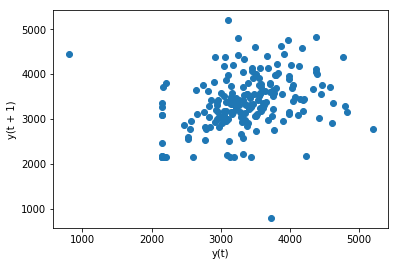

In [18]:
pd.plotting.lag_plot(cal_burn)

In [19]:
df_corr = pd.concat([cal_burn.shift(1), cal_burn], axis=1)
df_corr.columns = ['t-1','t+1']
result = df_corr.corr()
print(result)


          t-1       t+1
t-1  1.000000  0.327216
t+1  0.327216  1.000000


## Modeling

In [20]:
d_df = df

In [21]:
d_df.reset_index(inplace=True)

In [22]:
d_df['y'] = df.calories_burned
d_df['ds'] = pd.to_datetime(d_df.date)
d_df = d_df[['ds', 'y']]

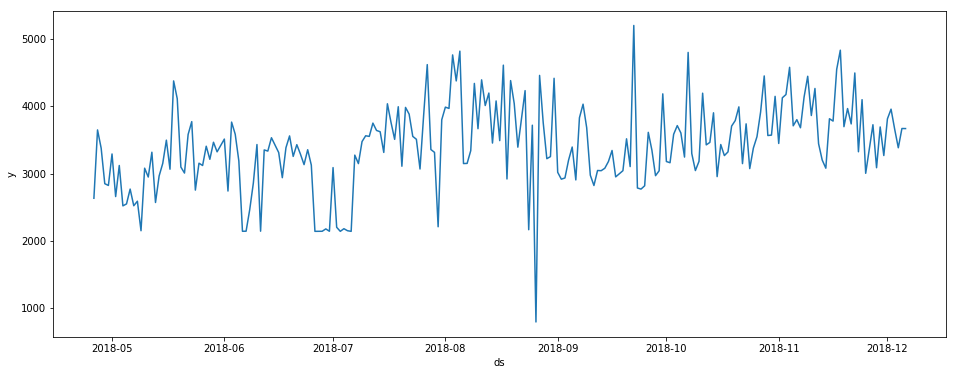

In [133]:
plt.figure(figsize=(16,6))
sns.lineplot(d_df.ds, d_df.y)

In [134]:
d_df['cap'] = 3700
d_df['floor'] = 2000

m = Prophet(growth='logistic', weekly_seasonality=True)
m.fit(d_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [135]:
future = m.make_future_dataframe(periods=180)
future['cap'] = 3700
future['floor'] = 2000
print(future.head())
print(future.tail())
print(d_df.tail())

          ds   cap  floor
0 2018-04-26  3700   2000
1 2018-04-27  3700   2000
2 2018-04-28  3700   2000
3 2018-04-29  3700   2000
4 2018-04-30  3700   2000
            ds   cap  floor
400 2019-05-31  3700   2000
401 2019-06-01  3700   2000
402 2019-06-02  3700   2000
403 2019-06-03  3700   2000
404 2019-06-04  3700   2000
            ds     y   cap  floor
220 2018-12-02  3957  3700   2000
221 2018-12-03  3660  3700   2000
222 2018-12-04  3384  3700   2000
223 2018-12-05  3670  3700   2000
224 2018-12-06  3669  3700   2000


In [136]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
400,2019-05-31,3774.687941,3028.955038,4485.444032
401,2019-06-01,3862.433755,3090.907044,4607.976669
402,2019-06-02,3856.378041,3088.311853,4674.756108
403,2019-06-03,3530.931706,2774.183770,4256.882730
404,2019-06-04,3590.565368,2823.658641,4287.772436


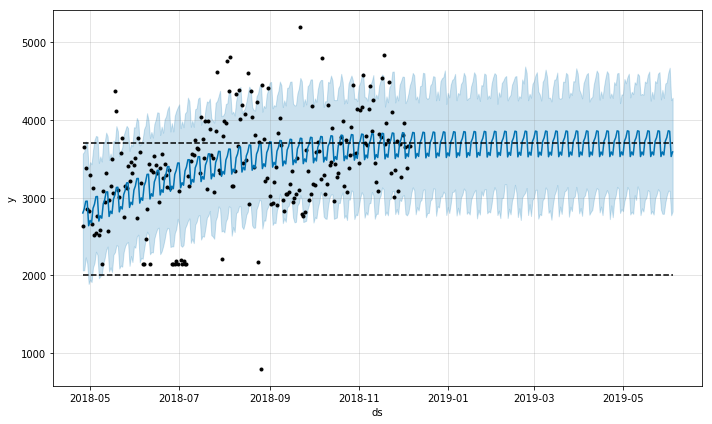

In [137]:
fig1 = m.plot(forecast)


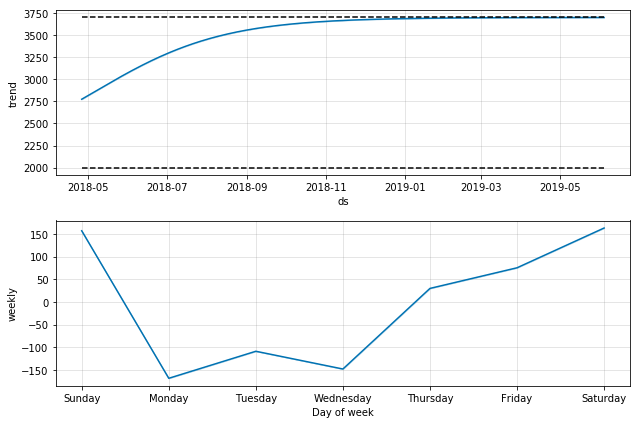

In [138]:
fig2 = m.plot_components(forecast)


In [139]:
from fbprophet.diagnostics import cross_validation, performance_metrics
# cross_validation(m, initial = 730, period = 180, horizon = 365, units = 'days')
df_cv = cross_validation(m, horizon='14 days')


df_p = performance_metrics(df_cv)
df_p.head(5)

INFO:fbprophet:Making 25 forecasts with cutoffs between 2018-06-07 00:00:00 and 2018-11-22 00:00:00


,horizon,mse,rmse,mae,mape,coverage
253,2 days,371383.462405,609.412391,508.996406,0.158587,0.742857
43,2 days,364167.642685,603.463042,504.308697,0.157874,0.742857
281,2 days,352809.334062,593.977554,491.898360,0.155292,0.742857
85,2 days,338592.435163,581.886961,477.268936,0.147217,0.771429
183,2 days,342437.066415,585.181225,480.890484,0.148192,0.771429


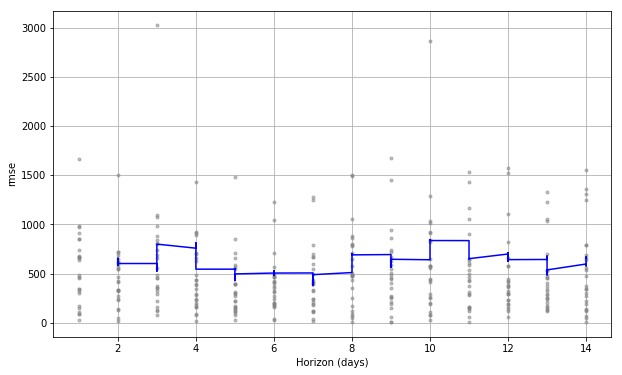

In [140]:
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component

# plot_forecast_component(m, forecast, 'yhat')

fig3 = plot_cross_validation_metric(df_cv, metric='rmse')


In [141]:
# need date range 2018-12-07 to 2018-12-28 225-246

In [142]:
missing_pred = forecast.loc[225:246][['ds','yhat']]

In [143]:
missing_pred.rename(columns={'yhat': 'calories_burned', 'ds': 'date'}, inplace=True)

In [144]:
cal_df = df[['date', 'calories_burned']]

In [145]:
full_df = cal_df.append(missing_pred)

In [146]:
full_df

,date,calories_burned
0,2018-04-26,2635.000000
1,2018-04-27,3649.000000
2,2018-04-28,3379.000000
3,2018-04-29,2851.000000
4,2018-04-30,2825.000000
5,2018-05-01,3292.000000
6,2018-05-02,2660.000000
7,2018-05-03,3121.000000
8,2018-05-04,2522.000000
9,2018-05-05,2551.000000


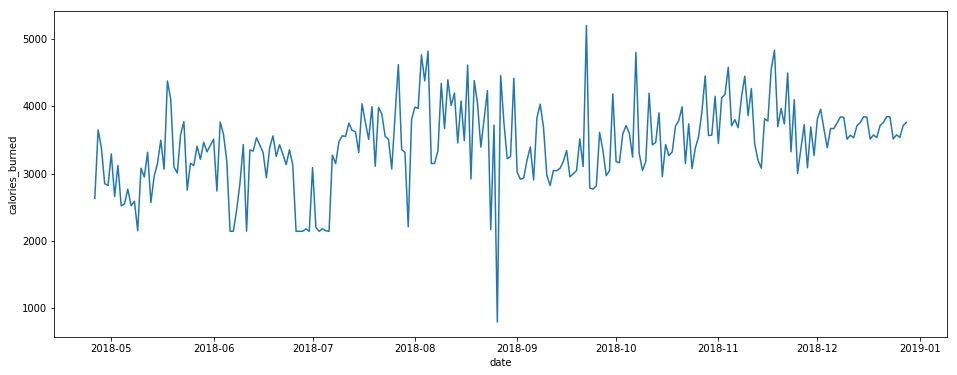

In [147]:
plt.figure(figsize=(16,6))
sns.lineplot(full_df.date, full_df.calories_burned)